In [1]:
import cv2
import imutils
import numpy as np
import cupy as cp
import math
import random
from os import listdir
from os.path import isfile, join
import io
from IPython.display import display
from PIL import Image
import time
from skimage.exposure import match_histograms

#random.seed(19)
z_step_counter = 0

%run ./variables.ipynb
%run ./utils.ipynb
%run ../../utils/image_utils.ipynb
%run ../../utils/data_utils.ipynb
%run ../../global_variables.ipynb

ref = cv2.imread(os.path.join(DATASETS_ROOT,"atlas/ref_img.png"), cv2.IMREAD_GRAYSCALE)
SAVE_TO_TMP = False

In [2]:
def pick_images(images_dict, n_range=[9,12]):
    # Pick random images and add them to list
    n = random.randint(n_range[0], n_range[1])
    rand_images = []
    for i in range(n):
        # choosing random images
        rand_key = np.random.choice(list(images_dict.keys()))
        rand_indice = np.random.randint(len(images_dict[rand_key]))
        rand_image_path = images_dict[rand_key][rand_indice]
        # loading image
        image_path = join(rand_image_path[0], rand_image_path[1])
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if SAVE_TO_TMP: 
            tmp_path = os.path.join(OUTPUT_TMP, "thumbnails/"+rand_key+str(i)+".png")
            check_dirs(tmp_path)
            cv2.imwrite(tmp_path, img)
        img = match_histograms(img, ref, multichannel=False).astype("uint8")
        #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
        rand_images.append({"data":img, "taxon":rand_key})
    return rand_images

In [30]:
def patchwork(tmp_images, simple_angles = True, size_px = 1000, overlapping=0, starter=None, scale=[5,5]):
    art_img = (np.ones((size_px, size_px))).astype(np.uint8)
    if starter is None:
        global_patch = np.zeros_like(art_img)
        global_patch_mask_rogn = np.zeros_like(art_img)
        individual_patches = []
    else:
        global_patch = starter[0]
        global_patch_mask_rogn = starter[1]
        individual_patches = starter[2]
    annotations = []
    global z_step_counter
    for img_obj in tmp_images:
        w, h = img_obj["data"].shape
        #rand_scale = np.random.randint(10, 20)/100
        rand_scale = (scale[0]+np.random.exponential(scale[1]))/100
        ratio = (rand_scale*size_px)/np.mean([w,h])
        img = resize_img(img_obj["data"], ratio)
        w, h = img.shape
        mask = np.ones_like(img)*255
        mask_rogn = round_rectangle(np.min([w,h])//2, w, h, value=255).astype("uint8")
        # Flipping
        if np.random.random()<0.5:
            img = cv2.flip(img, 0)
        if np.random.random()<0.5:
            img = cv2.flip(img, 1)
        # Rotating
        if simple_angles:
            angle = random.choice((0,90))
        else:
            angle = random.randint(0,360)

        rotated = imutils.rotate_bound(img, angle)
        rotated_mask = imutils.rotate_bound(mask, angle)
        rotated_mask_rogn = imutils.rotate_bound(mask_rogn, angle)
        #PLACING THE IMAGE WITHOUT OVERLAPPING
        #overlap_test = float("inf")
        overlapping_test = True
        n_stop = 200
        area = w*h
        #while overlap_test>area*overlapping and n_stop != 0:
        while overlapping_test and n_stop != 0:
            # TRANSLATING
            px, py = int(rotated.shape[0]/2), int(rotated.shape[1]/2)
            x, y = random.randint(0,size_px-1), random.randint(0,size_px-1) 
            xmin, xmax, ymin, ymax = x-px, x+px, y-py, y+py
            dxmin, dxmax = (0, -xmin)[xmin<0], (0, size_px-1-xmax)[xmax>size_px-1]
            dymin, dymax = (0, -ymin)[ymin<0], (0, size_px-1-ymax)[ymax>size_px-1]
            # PLACING ON TEMPORARY PATCH/MASL
            patch = np.zeros_like(art_img)
            patch_mask = np.zeros_like(art_img)
            patch_mask_rogn = np.zeros_like(art_img)
            patch[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask_rogn[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask_rogn[dxmin:2*px+dxmax, dymin:2*py+dymax]
            # Testing if there is overlapping by comparing to global mask
            #overlap_test = len(np.nonzero(np.logical_and(patch_mask, global_patch_mask_rogn))[0])
            overlapping_test=False
            for prev_patch in individual_patches:
                prev_patch_mask = prev_patch["patch_mask"]
                n_overlapping_pixels = len(np.nonzero(np.logical_and(patch_mask, prev_patch_mask))[0])
                n_pixels_prev_patch = len(np.nonzero(prev_patch_mask)[0])
                #print(n_overlapping_pixels, n_pixels_prev_patch)
                if n_overlapping_pixels>overlapping*n_pixels_prev_patch:
                    overlapping_test=True
            n_stop -= 1
        if n_stop > 0:
            individual_patches.append({
                "patch": patch.copy(), 
                "patch_mask": patch_mask_rogn.copy(), 
                "center": (int(math.ceil((np.mean([ymin+dymin, ymax+dymax])))), int(math.ceil((np.mean([xmin+dxmin, xmax+dxmax])))))})
            # (erosion to get rid of black edges)
            kernel_size = 3
            kernel = np.ones((kernel_size,kernel_size),np.uint8)
            #patch_mask = cv2.erode(patch_mask,kernel,iterations = 1)
            patch_mask_rogn = cv2.erode(patch_mask_rogn,kernel,iterations = 1)
            # filling global patches
            cv2.copyTo(patch, patch_mask_rogn, global_patch)
            cv2.copyTo(patch_mask_rogn, patch_mask_rogn, global_patch_mask_rogn)
            patch_mask_rogn[patch_mask_rogn>0]=1
            annotations.append({
                "taxon": img_obj["taxon"],
                "ymin": xmin+dxmin,
                "xmin": ymin+dymin,
                "ymax": xmax+dxmax,
                "xmax": ymax+dymax,
                "patch_mask": patch_mask_rogn,
                "z_index": z_step_counter
                
            })
            z_step_counter+=1
    #CREATING FINAL IMAGE
    cv2.copyTo(global_patch, global_patch_mask_rogn, art_img)
    if SAVE_TO_TMP: 
        tmp_patch = cv2.cvtColor(global_patch,cv2.COLOR_GRAY2RGB)
        conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        tmp_patch = cv2.drawContours(tmp_patch, conts, -1, (0,0,255), 3)
        cv2.imwrite(os.path.join(OUTPUT_TMP, "global_patch.png"), tmp_patch)
    return global_patch, global_patch_mask_rogn, annotations, individual_patches

In [31]:
def fast_img_filling(global_patch, global_patch_mask_rogn, individual_patches, sigma=10e3, verbose=False):
    # IMPROVED img_filling USING CUPY
    final_img = cp.asarray(global_patch)
    acc, accw = cp.zeros_like(final_img).astype(np.float32), cp.zeros_like(final_img).astype(np.float32)
    # Finding contours
    conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    height=global_patch.shape[0]
    width=global_patch.shape[1]
    if not hasattr(fast_img_filling, 'W'):
        indices = np.indices((height*2,width*2))
        xMap = cp.asarray(indices[0])
        yMap = cp.asarray(indices[1])
        d2 = cp.square(xMap - width) + cp.square(yMap - height)
        fast_img_filling.W = cp.exp(-d2/sigma)
        fast_img_filling.W[fast_img_filling.W<1e-10] = 1e-10
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if verbose and i%2000==0:
            print(i, "/", len(known))
            i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        w = fast_img_filling.W[height-ykp:2*height-ykp,width-xkp:2*width-xkp]
        acc += w*val
        accw += w
    acc = cp.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    
    # sticking the diatoms
    tmp_global_patch_mask_null = cp.asarray(global_patch_mask_rogn)==0
    #final_img[tmp_global_patch_mask_null]=acc_img[tmp_global_patch_mask_null]
    #final_img = cp.asnumpy(acc_img)
    dst = expand(cp.asnumpy(acc_img))
    if SAVE_TO_TMP: cv2.imwrite(os.path.join(OUTPUT_TMP, "gradient.png"), dst)
    center = (height//2, width//2)
    np.random.shuffle(individual_patches)
    for patch in individual_patches:
        ks = np.floor(abs(np.random.normal(0, 3, 1))).astype("uint8")[0]*2+1
        patch_img = cv2.GaussianBlur(patch["patch"],(ks,ks),0)
        src = expand(patch_img)
        mask = patch["patch_mask"]
        center=patch["center"]
        try:
            dst = cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)
        except ValueError:
            print("hey")
    return dst

In [32]:
def main_generator(images, simple_angles = False, size_px = 1000, verbose=False, overlapping=0, n_diatoms=[9,12], scale_diatoms=[10,10], n_dust=[15,30], scale_dust=[5,10]):    
    # Placing them randomly on the artboard
    global z_step_counter
    z_step_counter = 0
    images_dict_diatoms, images_dict_debris = images
    
    # Diatoms
    rand_images_diatoms = pick_images(images_dict_diatoms, n_diatoms)
    global_patch, global_patch_mask_rogn, annotations, individual_patches = patchwork(rand_images_diatoms, 
                                                                  simple_angles=simple_angles, 
                                                                  size_px=size_px, 
                                                                  overlapping=overlapping,
                                                                  scale=scale_diatoms)
    # Debris
    if not n_dust is None: 
        rand_images_debris = pick_images(images_dict_debris, n_dust)
        global_patch, global_patch_mask_rogn, annotations_dust, individual_patches = patchwork(rand_images_debris, 
                                                  simple_angles=simple_angles, 
                                                  size_px=size_px, 
                                                  overlapping=0.6, 
                                                  starter=[global_patch, global_patch_mask_rogn, individual_patches],
                                                  scale=scale_dust)
    
    # Filling the gaps
    final_image = fast_img_filling(global_patch, global_patch_mask_rogn, individual_patches, sigma=10e3, verbose=verbose)
        
    if verbose:
        print("Finished!")
        display(Image.fromarray(np.hstack([global_patch, global_patch_mask_rogn])))
        img_bb = final_image.copy()
        color = (255, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        for annotation in annotations:
            img_bb = cv2.rectangle(img_bb, (annotation["ymin"], annotation["xmin"]), (annotation["ymax"], annotation["xmax"]), color, 4)
            img_bb = cv2.putText(img_bb,  annotation["taxon"], (annotation["ymin"], annotation["xmin"]), font, fontScale, color, 6, cv2.LINE_AA) 
        display(Image.fromarray(img_bb))
    if SAVE_TO_TMP: cv2.imwrite(os.path.join(OUTPUT_TMP, "final_img.png"), final_image)
    return final_image, annotations

10.493407249450684 s!


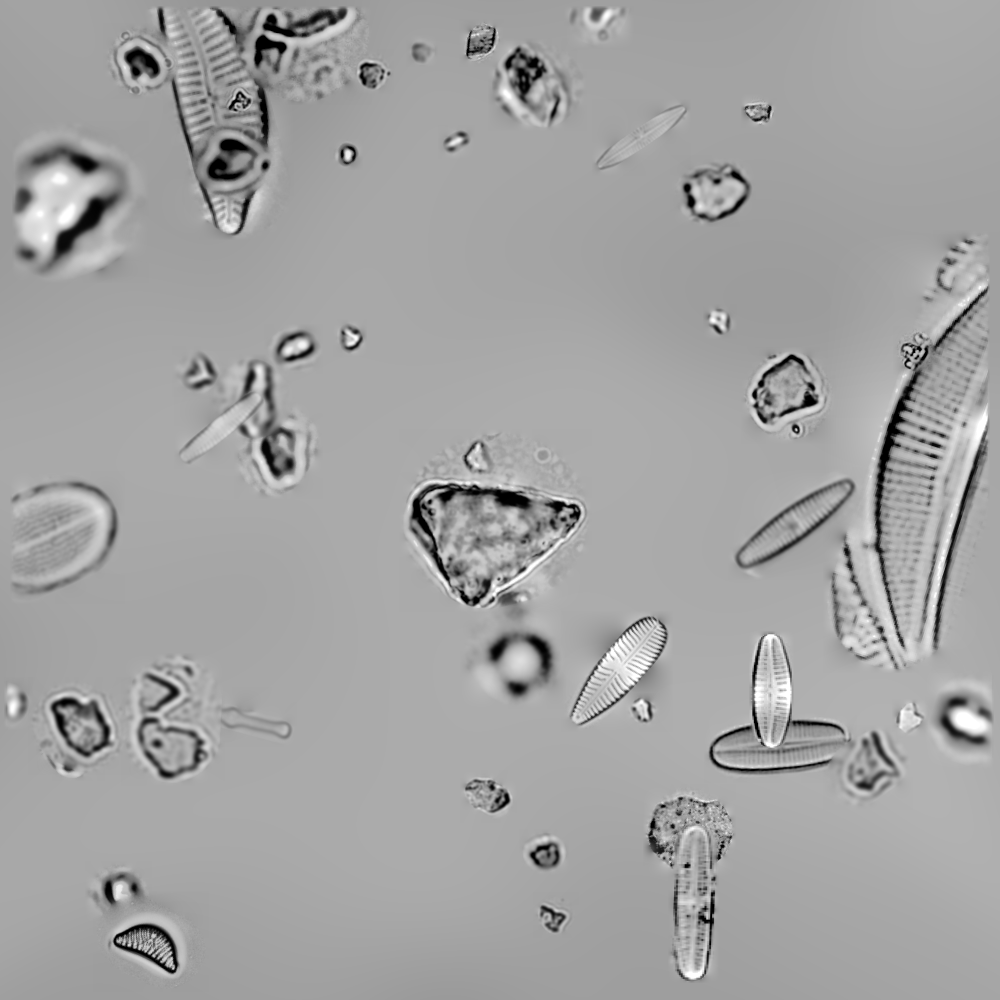

In [34]:
diatom_images = list_images(DATASET_PATH, diatoms=True)
debris_images = list_images(DATASET_DUST_PATH, diatoms=False)
start=time.time()
np.random.seed()
final_image, annotations = main_generator([diatom_images, debris_images],
                                          simple_angles = False, 
                                          size_px = 1000,
                                          verbose=False, 
                                          overlapping=0.3, 
                                          n_diatoms=[9,12],
                                          scale_diatoms=[7,4.5],                                          
                                          n_dust=[25,40],
                                          scale_dust=[3,4])
print(time.time()-start, "s!")
display(Image.fromarray(final_image))